In [1]:
import tensorflow as tf
from tensorflow import keras
tf.__version__

'2.0.0'

In [2]:
#建议采用GPU进行训练，需要使用tensorflow-gpu-2.0并设置memory_growth
for gpu in tf.config.experimental.list_physical_devices('GPU'):
    tf.config.experimental.set_memory_growth(gpu,True)

# 对小数据集使用卷积网络



拥有“很少”的样本可能意味着几百到几万张图像。作为一个实际示例，我们将重点关注在包含4000张猫和狗（2000只猫，2000只狗）图片的数据集中，将图像分类为“狗”还是“猫”。我们将使用2000张图片进行训练，使用1000张图片进行验证，最后使用1000张图片进行测试。

在本节中，我们将介绍解决该问题的一种基本策略：从头开始训练我们拥有的少量数据的新模型。我们将首先对2000个训练样本进行一次简单的训练，而无需进行任何正则化，从而为可以实现的目标设定基准。分类精度达到71％。此时我们的主要问题将是过拟合。我们将使用数据增强，这是一种缓解计算机视觉过度拟合的强大技术。通过利用数据增强，我们将改善我们的网络，使其准确性达到82％。

另外两种将深度学习应用于小型数据集的基本技术：使用预先训练的网络进行特征提取（这将使我们的准确度达到90％到93％），以及对预训练的网络进行微调。这三种策略结合在一起 从头开始训练一个小型模型，使用预训练的模型进行特征提取以及对预训练的模型进行微调 将构成您将来解决使用小数据进行计算机视觉问题的工具箱。

# 深度学习与小数据问题的相关性
有时您会听到深度学习仅在有大量数据可用时才起作用。这在一定程度上是正确的：深度学习的一个基本特征是，它能够自行在训练数据中找到有趣的特征，而无需进行人工特征工程，而只有在有大量训练样本时才能实现。对于输入样本非常高维的问题（例如图像），尤其如此。

但是，大量样本时相对的，相对于您训练的网络的大小和深度。仅用几十个样本就不可能训练卷积网络来解决复杂的问题，但是如果模型较小且做好了正则化，并且任务简单，则数百个就足够了。

因为卷积网络学到的时局部、平移不变的特征，他对于感知问题可以高效的利用数据，虽然数据相对较少，但是在非常小的图像数据集上从头开始训练一个卷积神经网络，仍然可以得到不错的结果，而且无须任何自定义的特征工程。此外深度学习模型本质上具有高度的可复用性

In [3]:
# 5-4将图像复制到训练、验证和测试的目录
import os,shutil

original_dataset_dir=r'E:\数据\kaggle_cat_vs_dog\train'
base_dir=r'E:\数据\kaggle_cat_vs_dog\cat_and_dogs_small'
os.mkdir(base_dir)

#分别对应划分后的训练，验证和测试目录
train_dir = os.path.join(base_dir, 'train')
os.mkdir(train_dir)
validation_dir = os.path.join(base_dir, 'validation')
os.mkdir(validation_dir)
test_dir = os.path.join(base_dir, 'test')
os.mkdir(test_dir)

# 猫的训练图像目录
train_cats_dir = os.path.join(train_dir, 'cats')
os.mkdir(train_cats_dir)

# 狗的训练图像目录
train_dogs_dir = os.path.join(train_dir, 'dogs')
os.mkdir(train_dogs_dir)

# 猫的验证图像目录
validation_cats_dir = os.path.join(validation_dir, 'cats')
os.mkdir(validation_cats_dir)

# 狗的验证图像目录
validation_dogs_dir = os.path.join(validation_dir, 'dogs')
os.mkdir(validation_dogs_dir)

# 猫的测试图像目录
test_cats_dir = os.path.join(test_dir, 'cats')
os.mkdir(test_cats_dir)

# 狗的测试图像目录
test_dogs_dir = os.path.join(test_dir, 'dogs')
os.mkdir(test_dogs_dir)

In [4]:
# 将前1000张猫的图像复制到train_cats_dir
fnames = ['cat.{}.jpg'.format(i) for i in range(1000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(train_cats_dir, fname)
    shutil.copyfile(src, dst)

# 将接下来500张猫的图像复制到validation_cats_dir
fnames = ['cat.{}.jpg'.format(i) for i in range(1000, 1500)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(validation_cats_dir, fname)
    shutil.copyfile(src, dst)
    
# 将接下来500张猫的图像复制到test_cats_dir
fnames = ['cat.{}.jpg'.format(i) for i in range(1500, 2000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(test_cats_dir, fname)
    shutil.copyfile(src, dst)
    
# 将前1000张狗的图像复制到train_dogs_dir
fnames = ['dog.{}.jpg'.format(i) for i in range(1000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(train_dogs_dir, fname)
    shutil.copyfile(src, dst)
    
# 将接下来500张狗的图像复制到validation_dogs_dir
fnames = ['dog.{}.jpg'.format(i) for i in range(1000, 1500)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(validation_dogs_dir, fname)
    shutil.copyfile(src, dst)
    
# 将接下来500张狗的图像复制到test_dogs_dir
fnames = ['dog.{}.jpg'.format(i) for i in range(1500, 2000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(test_dogs_dir, fname)
    shutil.copyfile(src, dst)

In [5]:
print('total training cat images:', len(os.listdir(train_cats_dir)))
print('total training dog images:', len(os.listdir(train_dogs_dir)))
print('total validation cat images:', len(os.listdir(validation_cats_dir)))
print('total validation dog images:', len(os.listdir(validation_dogs_dir)))
print('total test cat images:', len(os.listdir(test_cats_dir)))
print('total test dog images:', len(os.listdir(test_dogs_dir)))

total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500
total test cat images: 500
total test dog images: 500


# 
我们有2000个训练图像，然后是1000个验证图像和1000个测试图像。 在每个分组中，每个类别中的样本数均相同：这是一个平衡的二分类问题，这意味着分类准确度将是成功与否的适当衡量标准。

# 建立我们的网络
由于我们要处理更大的图像和更复杂的问题，因此我们将使我们的网络更大：它将具有一个Conv2D + MaxPooling2D阶段。这既可以增加网络的容量，又可以进一步减小特征图的尺寸，从而当我们到达Flatten层时，它们不会太大。在这里，由于我们从大小为150x150的输入（某种程度上是任意选择）开始，因此我们在Flatten层之前得到了大小为7x7的要素贴图。请注意，特征图的深度在网络中逐渐增加（从32到128），而特征图的大小在减小（从148x148到7x7）。在几乎所有的卷积网络中都会看到这种模式。由于我们正在实现二分类问题，因此我们以单个单元（大小为1的全连接层）和sigmoid激活来结束网络。

In [6]:
# 5-5将猫狗分类的小型卷积神经网络实例化
from tensorflow.keras import layers
from tensorflow.keras import models

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 128)       1

# 
我们将使用RMSprop优化器，因为最后一层是单一sigmoid单元，所以我们使用二元交叉熵损失函数。

In [8]:
# 5-6配置模型用于训练
model.compile(loss='binary_crossentropy',
             optimizer=keras.optimizers.RMSprop(lr=1e-4),
             metrics=['acc'])

# 数据预处理
将数据输入神经网络之前，应该将数据格式化为经过预处理的浮点数张量。

In [9]:
# 5-7读取图像
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from keras.preprocessing.image import ImageDataGenerator

# 将所有图像乘以1/255
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # 目标目录
        train_dir,
        # 将所有图像的大小调整为150*150
        target_size=(150, 150),
        batch_size=20,
        # 因为使用了binary_crossentropy(二元交叉熵损失函数)损失，所以需要用二进制标签
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

Using TensorFlow backend.


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


# 
查看生成器的输出：它生成了150×150的RGB图像形状为（20，150，150，3）与二进制标签形状为（20，）组成的批量。

In [10]:
for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

data batch shape: (20, 150, 150, 3)
labels batch shape: (20,)


# 
利用生成器，我们让模型对数据进行拟合，我们使用fit_generator方法来拟合，它在数据生成器上的效果和fit相同。它的第一个参数应该是一个python生成器。因为数据是不断生成的，所以要知道每一轮需要从生成器中抽取多少个样本，这是steps_per_epoch参数的作用，steps_per_epoch=len(data)//batch_size
。即运行了steps_per_epoch次梯度下降后，进入下一个轮次。

In [11]:
# 5-8利用批量生成其拟合模型
history=model.fit_generator(train_generator,
                           steps_per_epoch=100,
                           epochs=30,
                           validation_data=validation_generator,
                           validation_steps=50)

Epoch 1/30
100/100 [==============================] - 12s 121ms/step - loss: 0.6866 - acc: 0.5525 - val_loss: 0.6619 - val_acc: 0.6170
Epoch 2/30
100/100 [==============================] - 8s 80ms/step - loss: 0.6451 - acc: 0.6390 - val_loss: 0.6268 - val_acc: 0.6610
Epoch 3/30
100/100 [==============================] - 8s 80ms/step - loss: 0.5956 - acc: 0.6740 - val_loss: 0.6656 - val_acc: 0.6180
Epoch 4/30
100/100 [==============================] - 8s 79ms/step - loss: 0.5607 - acc: 0.7055 - val_loss: 0.5858 - val_acc: 0.6840
Epoch 5/30
100/100 [==============================] - 8s 80ms/step - loss: 0.5366 - acc: 0.7235 - val_loss: 0.5956 - val_acc: 0.6660
Epoch 6/30
100/100 [==============================] - 8s 81ms/step - loss: 0.5082 - acc: 0.7505 - val_loss: 0.5785 - val_acc: 0.6990
Epoch 7/30
100/100 [==============================] - 8s 84ms/step - loss: 0.4782 - acc: 0.7675 - val_loss: 0.5600 - val_acc: 0.6990
Epoch 8/30
100/100 [==============================] - 8s 81ms/step 

In [12]:
# 5-9保存模型
model.save('cats_and_dogs_small_1.h5')

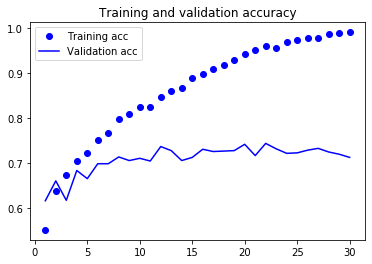

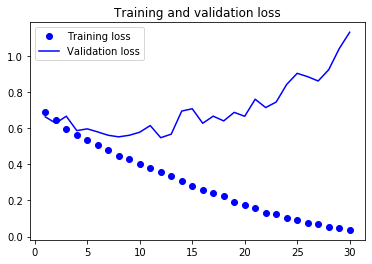

In [14]:
# 5-10绘制训练过程中的损失曲线和精度曲线
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs=range(1, len(acc)+1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


# 
从图中可知出现了过拟合，验证损失仅在5个轮次后就到达最小值了，然后保持不变，我们使用数据增强的方法降低过拟合。


# 使用数据扩充
过拟合的原因是学习样本太少，导致无法训练出能泛化到新数据的模型，如果有无限的数据，模型能够观察到数据分布的所有内容，这样就不会过拟合了。数据增强是从现有的训练样本中生成更多的数据，其方法是利用多种能够生成可信图像的随机变换来增加。

In [15]:
# 使5-11用数据增强
datagen = ImageDataGenerator(
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

# 
rotation_range 是角度值(在0-18范围内)，表示图像随机旋转的角度范围。

width_shift和height_shift 是图像在水平或垂直方式上平移的范围

shear_range 随机错切的角度

zoom_range 图像随机缩放的范围

horizontal_flip 随机将一半图像水平反转

fill_mode 用于填充醒创建像素的方法

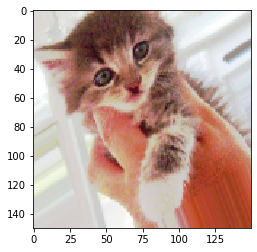

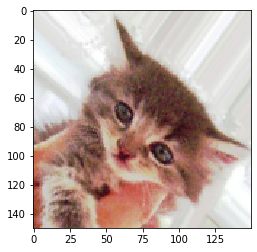

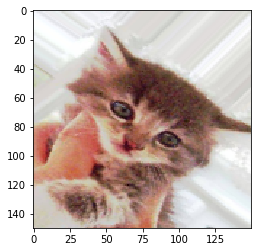

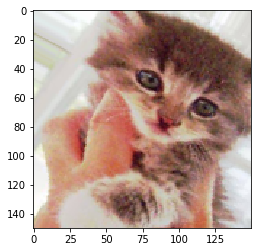

In [16]:
# 5-12显示几个随机增强后的训练图像
from keras.preprocessing import image

fnames = [os.path.join(train_cats_dir, fname) for fname in os.listdir(train_cats_dir)]

# 选择一张图像
img_path = fnames[3]

# 读取图像并调整大小
img = image.load_img(img_path, target_size=(150, 150))

# 将其转换为Numpy数组
x = image.img_to_array(img)

# 形状改变为（1，150，150，3）
x = x.reshape((1,) + x.shape)

i = 0
for batch in datagen.flow(x, batch_size=1):
    plt.figure(i)
    imgplot = plt.imshow(image.array_to_img(batch[0]))
    i += 1
    if i % 4 == 0:
        break

plt.show()

In [17]:
# 5-13定义一个包含dropout的新卷积神经网络

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=keras.optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

In [18]:
# 5-14利用数据增强生成器训练卷积网络
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,)

# 不增强验证数据
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # 目标目录
        train_dir,
        # 调整形状
        target_size=(150, 150),
        batch_size=32,
        # 设置二进制标签
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary')

history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=100,
      validation_data=validation_generator,
      validation_steps=50)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/100
100/100 [==============================] - 23s 226ms/step - loss: 0.6929 - acc: 0.5085 - val_loss: 0.6782 - val_acc: 0.5082
Epoch 2/100
100/100 [==============================] - 20s 204ms/step - loss: 0.6767 - acc: 0.5647 - val_loss: 0.6544 - val_acc: 0.6003
Epoch 3/100
100/100 [==============================] - 21s 208ms/step - loss: 0.6634 - acc: 0.5942 - val_loss: 0.6561 - val_acc: 0.5628
Epoch 4/100
100/100 [==============================] - 21s 208ms/step - loss: 0.6498 - acc: 0.6142 - val_loss: 0.6134 - val_acc: 0.6599
Epoch 5/100
100/100 [==============================] - 20s 204ms/step - loss: 0.6296 - acc: 0.6369 - val_loss: 0.5914 - val_acc: 0.6878
Epoch 6/100
100/100 [==============================] - 21s 215ms/step - loss: 0.6120 - acc: 0.6610 - val_loss: 0.6031 - val_acc: 0.6510
Epoch 7/100
100/100 [==============================] - 21s 205ms/step - loss: 0.6060 - acc: 0.6740 -

100/100 [==============================] - 21s 205ms/step - loss: 0.4042 - acc: 0.8119 - val_loss: 0.4472 - val_acc: 0.7976
Epoch 61/100
100/100 [==============================] - 20s 196ms/step - loss: 0.4303 - acc: 0.8074 - val_loss: 0.4173 - val_acc: 0.8027
Epoch 62/100
100/100 [==============================] - 21s 213ms/step - loss: 0.4138 - acc: 0.8068 - val_loss: 0.4325 - val_acc: 0.8027
Epoch 63/100
100/100 [==============================] - 21s 210ms/step - loss: 0.4116 - acc: 0.8087 - val_loss: 0.4271 - val_acc: 0.8065
Epoch 64/100
100/100 [==============================] - 22s 219ms/step - loss: 0.4114 - acc: 0.8078 - val_loss: 0.4661 - val_acc: 0.7887 loss: 0.4
Epoch 65/100
100/100 [==============================] - 21s 205ms/step - loss: 0.4257 - acc: 0.8087 - val_loss: 0.4231 - val_acc: 0.8039
Epoch 66/100
100/100 [==============================] - 22s 215ms/step - loss: 0.4122 - acc: 0.8056 - val_loss: 0.4275 - val_acc: 0.8090
Epoch 67/100
100/100 [======================

In [19]:
# 5-15保存模型
model.save('cats_and_dogs_small_2.h5')

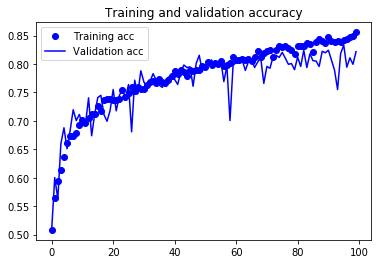

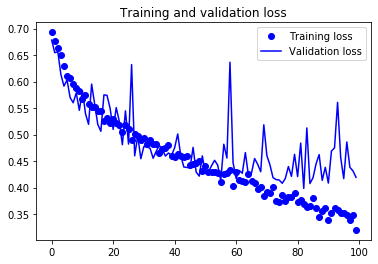

In [20]:
# 绘制训练过程中的损失曲线和精度曲线
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()